In [1358]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from statsmodels.api import OLS
from statsmodels.api import add_constant
import statsmodels.api as sm
import datetime

#import pydotplus
#import io
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline
from matplotlib import pyplot
default_dims = (13, 10)
import seaborn.apionly as sns #sets up styles and gives us more plotting options
sns.set_style("whitegrid")
sns.set_context("poster")
sns.reset_orig()

In [1359]:
five_factor_df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', index_col = 'Date')
nan_rows = five_factor_df.isnull().T.any().T
five_factor_df = five_factor_df[~nan_rows]
print(np.shape(five_factor_df))
five_factor_df.head()

(13657, 6)


,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
19630701,-0.67,0.00,-0.32,0.01,0.15,0.012
19630702,0.79,-0.27,0.27,-0.08,-0.19,0.012
19630703,0.63,-0.17,-0.09,0.19,-0.33,0.012
19630705,0.40,0.08,-0.28,0.07,-0.33,0.012
19630708,-0.63,0.04,-0.17,-0.31,0.13,0.012


In [1360]:
five_factor_df.index = pd.to_datetime(five_factor_df.index,format='%Y%m%d')

In [1361]:
three_factor_df = pd.read_csv('F-F_Research_Data_Factors_daily.CSV', index_col = 'Date')
nan_rows = three_factor_df.isnull().T.any().T
three_factor_df = three_factor_df[~nan_rows]
print(np.shape(three_factor_df))
three_factor_df.head()

(24077, 4)


,Mkt-RF,SMB,HML,RF
Date,,,,
19260701,0.10,-0.24,-0.28,0.009
19260702,0.45,-0.32,-0.08,0.009
19260706,0.17,0.27,-0.35,0.009
19260707,0.09,-0.59,0.03,0.009
19260708,0.21,-0.36,0.15,0.009


In [1362]:
three_factor_df.index = pd.to_datetime(three_factor_df.index,format='%Y%m%d')

In [1363]:
three_factors = [x for x in three_factor_df.columns if x != 'Date' and x != 'RF']
five_factors = [x for x in five_factor_df.columns if x != 'Date' and x != 'RF']

Mkt-RF Mean: 0.05606913183279745, Mkt-RF Stdev: 0.7872587049583424
SMB Mean: 0.0031189710610932428, SMB Stdev: 0.48855148651674307
HML Mean: 0.00043408360128617546, HML Stdev: 0.4668905536240676
RMW Mean: -7.234726688102836e-05, RMW Stdev: 0.30505427998461854
CMA Mean: -0.006197749196141472, CMA Stdev: 0.2938278737903466


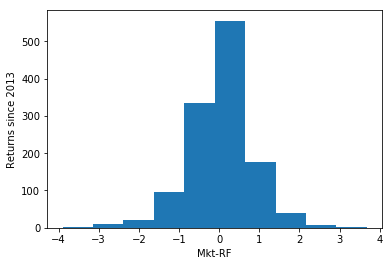

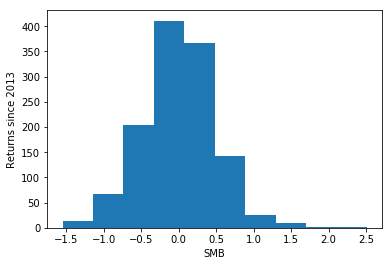

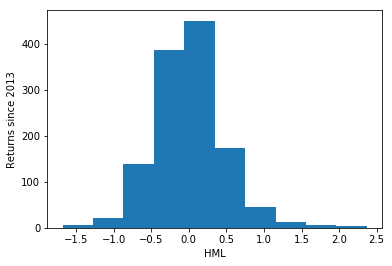

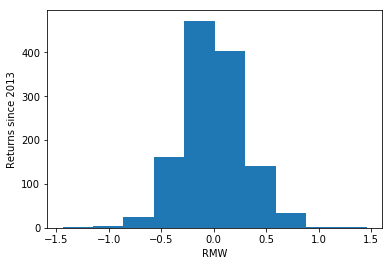

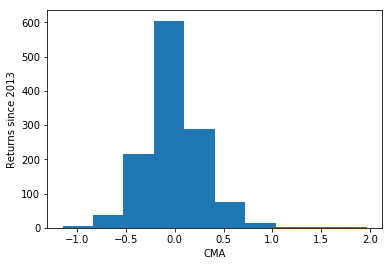

In [1388]:
for factor in five_factors:
    fig, ax = pyplot.subplots()
    plt.hist(five_factor_df[factor])
    print('{} Mean: {}, {} Stdev: {}'.format(factor, np.mean(five_factor_df[factor]), factor, np.std(five_factor_df[factor])))
    ax.set_xlabel(factor);
    ax.set_ylabel('Returns since 2013');

In [1365]:
stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE', 'AXLE']
# stocks_held = ['USAK', 'RHDGF', 'DXLG', 'NUSMF', 'LEE']

In [1366]:
quantities = [180, 110, 1000, 8000, 425, 2000]
# quantities = [180, 110, 1000, 8000, 425]

In [1367]:
ptf_dict = {stocks_held[i]: quantities[i] for i in range(len(quantities))}

In [1368]:
dfs = []
for stock in stocks_held:
    if stock != 'AXLE':
        stock_df = pd.read_csv('{}.csv'.format(stock), index_col = None)
        stock_df['Stock'] = stock
        dfs.append(stock_df)

# Adds in last dataframe at the end to keep them in order
df = pd.concat(dfs)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,7.5,7.5,7,7.125,7.125,1256400,USAK
1,1992-03-20,7.375,7.625,7.125,7.25,7.25,262800,USAK
2,1992-03-23,7.25,7.625,7.25,7.25,7.25,43800,USAK
3,1992-03-24,7.5,7.625,7.25,7.5,7.5,73600,USAK
4,1992-03-25,7.625,7.625,7.25,7.625,7.625,28000,USAK


In [1369]:
df['Date'] = pd.to_datetime(df['Date'])

In [1370]:
df = df.convert_objects(convert_numeric=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [1371]:
df.index = range(len(df))
df['Open'] = [df['Open'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df['Close'] = [df['Close'][i] * ptf_dict[df['Stock'][i]] for i in range(len(df))]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock
0,1992-03-19,1350.0,7.500,7.000,1282.5,7.125,1256400.0,USAK
1,1992-03-20,1327.5,7.625,7.125,1305.0,7.250,262800.0,USAK
2,1992-03-23,1305.0,7.625,7.250,1305.0,7.250,43800.0,USAK
3,1992-03-24,1350.0,7.625,7.250,1350.0,7.500,73600.0,USAK
4,1992-03-25,1372.5,7.625,7.250,1372.5,7.625,28000.0,USAK


In [1372]:
AXLE_df = pd.read_csv('AXLE.csv', index_col = None)

In [1373]:
AXLE_df['Stock'] = 'AXLE'
AXLE_df['Date'] = pd.to_datetime(AXLE_df['Date'])
AXLE_df = AXLE_df.convert_objects(convert_numeric=True)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [1374]:
AXLE_df['Last Price'] = ptf_dict['AXLE'] * AXLE_df['Last Price']
return_list = [np.log(AXLE_df['Last Price'][i]) - np.log(AXLE_df['Last Price'][i + 1]) for i in range(len(AXLE_df) - 1)]
AXLE_df = AXLE_df.drop(AXLE_df.index[-1])
AXLE_df['Returns'] = return_list 

In [1375]:
df['Returns'] = np.log(df['Close']) - np.log(df['Open'])

In [1376]:
df = pd.concat([df, AXLE_df])

In [1377]:
start_date = datetime.datetime(2012, 10, 19)

In [1378]:
df = df[df['Date'] >= start_date]

In [1379]:
three_factor_df = three_factor_df[three_factor_df.index >= datetime.datetime(2012, 10, 19)]

In [1380]:
five_factor_df = five_factor_df[five_factor_df.index >= datetime.datetime(2012, 10, 19)]

In [1381]:
grouped_by_stock = df.groupby('Stock')

In [1382]:
grouped_by_date = df.groupby('Date')

In [1383]:
portfolio_values = grouped_by_date.sum()
portfolio_values.head()

,Adj Close,Close,High,Last Price,Low,Open,Returns,SMAVG (15),Volume
Date,,,,,,,,,
2012-10-19,26.674713,14931.25,32.10,NaN,30.18,15167.15,-0.050744,NaN,1373082.0
2012-10-22,26.554713,14442.40,30.71,NaN,30.16,14835.85,-0.052136,NaN,316500.0
2012-10-23,26.574713,14286.30,30.49,NaN,30.12,14322.25,0.035713,NaN,192200.0
2012-10-24,27.710764,13846.70,31.97,NaN,31.59,14510.35,-0.061278,NaN,270100.0
2012-10-25,27.610764,13912.65,31.79,NaN,31.59,13862.30,-0.008985,NaN,181500.0


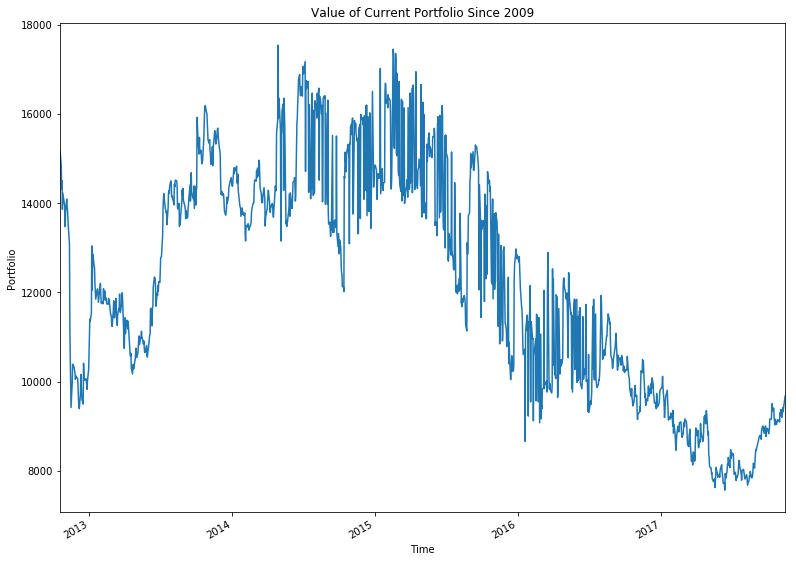

In [1384]:
fig, ax = plt.subplots(figsize=default_dims)
portfolio_values['Open'].plot();
ax.set_xlabel('Time');
ax.set_ylabel('Portfolio');
ax.set_title('Value of Current Portfolio Since 2013');

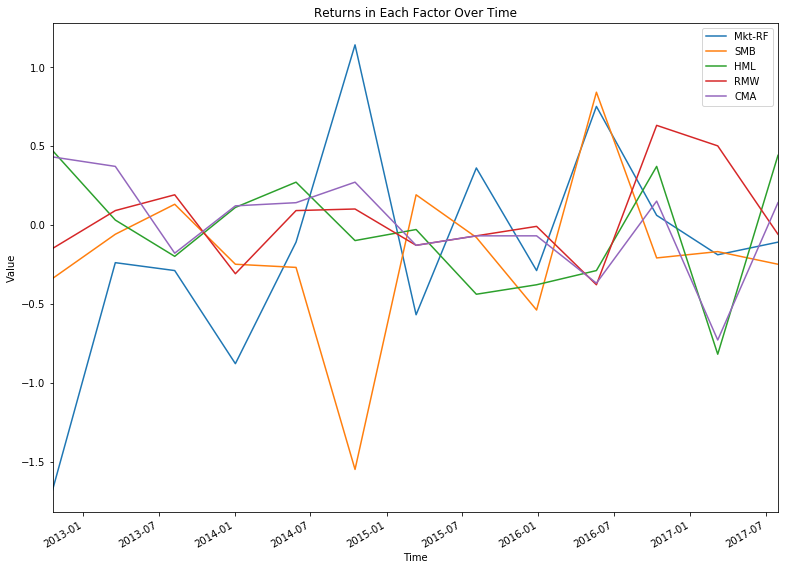

In [1385]:
msk = [True if i % 100 ==0 else False for i in range(len(three_factor_df))]
fig, ax = plt.subplots(figsize=default_dims)
for factor in five_factors:
    five_factor_df[factor][msk].plot(legend = True);
ax.set_xlabel('Time');
ax.set_ylabel('Value');
ax.set_title('Returns in Each Factor Over Time');

Mkt-RF Mean: 0.05606913183279745, Mkt-RF Stdev: 0.7872587049583424
SMB Mean: 0.0031189710610932428, SMB Stdev: 0.48855148651674307
HML Mean: 0.00043408360128617546, HML Stdev: 0.4668905536240676
RMW Mean: -7.234726688102836e-05, RMW Stdev: 0.30505427998461854
CMA Mean: -0.006197749196141472, CMA Stdev: 0.2938278737903466


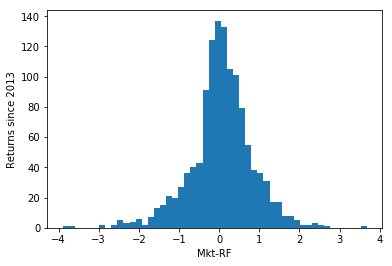

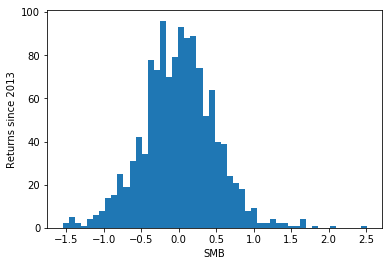

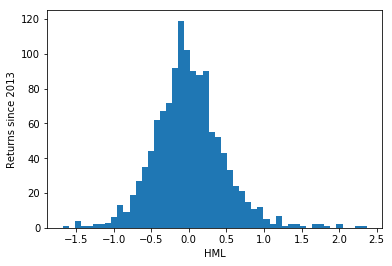

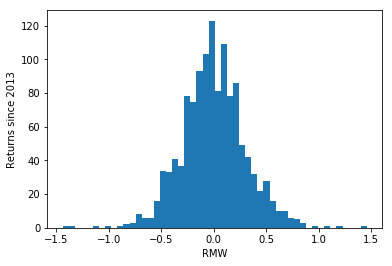

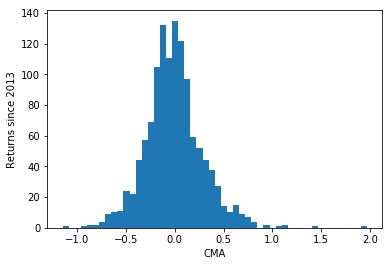

In [1386]:
for factor in five_factors:
    fig, ax = pyplot.subplots()
    plt.hist(five_factor_df[factor], bins = 50)
    print('{} Mean: {}, {} Stdev: {}'.format(factor, np.mean(five_factor_df[factor]), factor, np.std(five_factor_df[factor])))
    ax.set_xlabel(factor);
    ax.set_ylabel('Returns since 2013');

**In-sample evaluation**

In [1311]:
df_three = pd.concat([portfolio_values, three_factor_df], axis=1, join='inner')

In [1312]:
df_five = pd.concat([portfolio_values, five_factor_df], axis=1, join='inner')

In [1313]:
x_three = sm.add_constant(df_three[three_factors])

In [1314]:
x_five = sm.add_constant(df_five[five_factors])

In [1315]:
y = df_three['Returns']

In [1316]:
three_factor_OLS = sm.OLS(y, x_three.values)
three_factor_results = three_factor_OLS.fit()
three_factor_results.summary(xname = ['const'] + three_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     24.10
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           3.70e-15
Time:                        15:49:31   Log-Likelihood:                 1011.8
No. Observations:                1244   AIC:                            -2016.
Df Residuals:                    1240   BIC:                            -1995.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.498      0.619      -0.008       0.004
Mkt-RF         0.0235      0.004      5.910      0.000       0.016       0.031
SMB            0.0295      0.006      4.581      0.000       0.017       0.042
HML            0.0021      0.007      0.323      0.747      -0.011       0.015
==============================================================================
Omnibus:                      630.208   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21747.027
Skew:                           1.702   Prob(JB):                         0.00
Kurtosis:                      23.198   Cond. No.                         2.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1317]:
five_factor_OLS = sm.OLS(y, x_five.values)
five_factor_results = five_factor_OLS.fit()
five_factor_results.summary(xname = ['const'] + five_factors)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     17.13
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           2.07e-16
Time:                        15:49:31   Log-Likelihood:                 1018.2
No. Observations:                1244   AIC:                            -2024.
Df Residuals:                    1238   BIC:                            -1994.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.485      0.628      -0.007       0.004
Mkt-RF         0.0275      0.004      6.537      0.000       0.019       0.036
SMB            0.0326      0.007      4.853      0.000       0.019       0.046
HML           -0.0173      0.008     -2.047      0.041      -0.034      -0.001
RMW            0.0107      0.011      0.971      0.332      -0.011       0.032
CMA            0.0423      0.014      3.095      0.002       0.015       0.069
==============================================================================
Omnibus:                      644.306   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22861.537
Skew:                           1.751   Prob(JB):                         0.00
Kurtosis:                      23.707   Cond. No.                         4.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1318]:
capm_df = pd.read_csv('SPY.csv',index_col = 'Date')

In [1319]:
capm_df.index = pd.to_datetime(capm_df.index)

In [1320]:
df_train_capm = portfolio_values
df_train_capm['Market'] = np.log(capm_df['Close']) - np.log(capm_df['Open'])

In [1321]:
x_capm = sm.add_constant(df_train_capm['Market'])
y_capm = df_train_capm['Returns']

In [1322]:
capm_OLS = sm.OLS(y_capm, x_capm)
capm_results = capm_OLS.fit()
capm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     71.92
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           6.12e-17
Time:                        15:49:31   Log-Likelihood:                 1049.2
No. Observations:                1277   AIC:                            -2094.
Df Residuals:                    1275   BIC:                            -2084.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.003     -0.206      0.837      -0.006       0.005
Market         4.1713      0.492      8.481      0.000       3.206       5.136
==============================================================================
Omnibus:                      601.310   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19008.483
Skew:                           1.553   Prob(JB):                         0.00
Kurtosis:                      21.644   Cond. No.                         165.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Out-of-sample evaluation**

In [1323]:
def split(x,y):
    np.random.seed(9001)
    msk = np.random.rand(len(x)) < .75
    return x[msk], x[~msk], y[msk], y[~msk]

In [1324]:
x_train_three, x_test_three, y_train, y_test = split(x_three, y)

In [1325]:
three_factor_OLS = sm.OLS(y_train, x_train_three.values)
results_sm = three_factor_OLS.fit()
print('Three factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_three.values))))

Three factor test r2 of 0.037517106956969415


In [1326]:
x_train_five, x_test_five, y_train, y_test = split(x_five, y)

In [1327]:
five_factor_OLS = sm.OLS(y_train, x_train_five.values)
results_sm = five_factor_OLS.fit()
print('Five factor test r2 of {}'.format(r2_score(y_test, results_sm.predict(x_test_five.values))))

Five factor test r2 of 0.03861363794348216


In [1328]:
x_train_capm, x_test_capm, y_train_capm, y_test_capm = split(x_capm, y_capm)

In [1329]:
capm_OLS = sm.OLS(y_train_capm, x_train_capm.values)
results_sm = capm_OLS.fit()
print('CAPM test r2 of {}'.format(r2_score(y_test_capm, results_sm.predict(x_test_capm.values))))

CAPM test r2 of 0.00987989942112033


**EDA for Value Factor**

In [1330]:
value_df = pd.read_csv('RZV.csv', index_col = 'Date')

In [1331]:
value_df.index = pd.to_datetime(value_df.index)

In [1332]:
df_value = portfolio_values
df_value['Value'] = np.log(value_df['Close']) - np.log(value_df['Open'])
df_value = df_value.dropna()

In [1333]:
x_value = sm.add_constant(df_value['Value'])
y_value = df_value['Returns']

In [1334]:
value_OLS = sm.OLS(y_value, x_value)
value_results = value_OLS.fit()
value_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                 0.0001196
Date:                Thu, 16 Nov 2017   Prob (F-statistic):              0.991
Time:                        15:49:34   Log-Likelihood:                 38.759
No. Observations:                 173   AIC:                            -73.52
Df Residuals:                     171   BIC:                            -67.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113      0.015      0.762      0.447      -0.018       0.040
Value          0.0174      1.590      0.011      0.991      -3.121       3.156
==============================================================================
Omnibus:                       95.794   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              862.706
Skew:                           1.833   Prob(JB):                    4.63e-188
Kurtosis:                      13.307   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1335]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of -0.02156766348128336


In [1336]:
x_value = df_five['SMB']
y_value = df_five['Returns']

In [1337]:
x_train_value, x_test_value, y_train_value, y_test_value = split(x_value, y_value)
value_OLS = sm.OLS(y_train_value.values, x_train_value.values)
results_sm = value_OLS.fit()
print('Value factor test r2 of {}'.format(r2_score(y_test_value, results_sm.predict(x_test_value.values))))

Value factor test r2 of 0.04018357532819217


In [1338]:
grouped_by_stock.sum()

,Adj Close,Close,High,Last Price,Low,Open,Returns,SMAVG (15),Volume
Stock,,,,,,,,,
AXLE,NaN,NaN,NaN,116982.6,NaN,NaN,-0.064197,1265301.0,1299915.0
DXLG,5971.330000,5.971330e+06,6094.660000,NaN,5844.010000,5.975170e+06,-1.074313,NaN,207148100.0
LEE,3396.350000,1.443449e+06,3484.690000,NaN,3307.860000,1.444231e+06,-0.879988,NaN,328566100.0
NUSMF,361.000000,2.888000e+06,373.870000,NaN,347.280000,2.885840e+06,0.814529,NaN,127931200.0
RHDGF,16510.290043,2.054872e+06,18756.985110,NaN,18595.037589,2.053733e+06,0.517415,NaN,5975789.0
USAK,17906.519996,3.223174e+06,18358.069998,NaN,17472.149995,3.221932e+06,1.089502,NaN,81805100.0


In [1339]:
for stock in stocks_held:
    stock_group = grouped_by_stock.get_group(stock).groupby('Date').sum()
    temp_df = pd.concat([stock_group, five_factor_df], axis=1, join='inner')
    temp_df = temp_df[five_factors + ['Returns']].dropna()
    x = sm.add_constant(temp_df[five_factors])
    y = temp_df['Returns']
    x_train, x_test, y_train, y_test = split(x, y)
    OLS = sm.OLS(y_train, x_train)
    results = OLS.fit()
    print(results.summary(title=stock))

                                     USAK                                     
Dep. Variable:                Returns   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     18.88
Date:                Thu, 16 Nov 2017   Prob (F-statistic):           6.63e-18
Time:                        15:49:36   Log-Likelihood:                 1888.7
No. Observations:                 926   AIC:                            -3765.
Df Residuals:                     920   BIC:                            -3736.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        8.11e-05      0.001      0.078      0.9

                                     AXLE                                     
Dep. Variable:                Returns   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.198
Date:                Thu, 16 Nov 2017   Prob (F-statistic):              0.314
Time:                        15:49:37   Log-Likelihood:                 77.030
No. Observations:                 127   AIC:                            -142.1
Df Residuals:                     121   BIC:                            -125.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.012     -0.185      0.8